# The Neighbourhood Comparison of Two Cities: Istanbul and Toronto

## 1.Toronto Neighbourhoods Geocoding and Visualization 

In [1]:
#Importing libraries
! pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests
import pandas as pd

### Initiating Beautiful Soup for web scraping

**Postal codes** of the neighbourhoods in Toronto is obtained from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
html_doc = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_doc, 'lxml')
table = soup.table
all_rows = table.find_all('tr')

#"For" loops are used to obtain each row from the wiki table and then the dataframe is created by using Pandas library.
l = []
for tr_val in all_rows:
     td = tr_val.find_all('td')
     row = [td_val.text.strip() for td_val in td if td_val.text.strip()]
     if row:
        l.append(row)
        
#Creating a dataframe for Toronto postal codes.
df_canada = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
#Getting only assigned boroughs. 
df_canada_borough = df_canada.loc[df_canada['Borough'] != 'Not assigned'].reset_index(drop=True)
#Combining the neighbourhoods that share same postal code.
df_canada_borough['Neighbourhood'] = df_canada_borough.groupby(['PostalCode'])['Neighbourhood'].transform(lambda x: ', '.join(x))
df_canada_borough.drop_duplicates(subset = 'PostalCode', inplace = True)
df_canada_final = df_canada_borough.reset_index(drop=True)

print(df_canada_final.shape)
df_canada_final.head(10)

(103, 3)


PostalCode           Borough                     Neighbourhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto                      Harbourfront
3        M6A        North York  Lawrence Heights, Lawrence Manor
4        M7A  Downtown Toronto                      Queen's Park
5        M9A      Queen's Park                      Not assigned
6        M1B       Scarborough                    Rouge, Malvern
7        M3B        North York                   Don Mills North
8        M4B         East York   Woodbine Gardens, Parkview Hill
9        M5B  Downtown Toronto          Ryerson, Garden District

**Geospatial data** of the neighbourhoods in Toronto is obtained from  http://cocl.us/Geospatial_data and merged with the dataframe containing postal codes. 

In [3]:
#Loading the data
!wget -q -O 'toronto_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')
geoloc_toronto = pd.read_csv('toronto_data.csv')

#Merging two dataframes.
df_toronto_final = pd.merge(df_canada_final,geoloc_toronto, left_on='PostalCode', right_on='Postal Code')
df_x = df_toronto_final.drop(['Postal Code'],axis=1)

print(df_x.shape)
df_x.head(10)

Data downloaded!
(103, 5)


PostalCode           Borough                     Neighbourhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto                      Harbourfront  43.654260   
3        M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4        M7A  Downtown Toronto                      Queen's Park  43.662301   
5        M9A      Queen's Park                      Not assigned  43.667856   
6        M1B       Scarborough                    Rouge, Malvern  43.806686   
7        M3B        North York                   Don Mills North  43.745906   
8        M4B         East York   Woodbine Gardens, Parkview Hill  43.706397   
9        M5B  Downtown Toronto          Ryerson, Garden District  43.657162   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494  
5 -79.532242  
6 -79.194353  
7 -79.352188  
8 -79.309937  
9 -79.378937

Folium was installed in order to visualize the neighbourhood data points. 

In [4]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [5]:
# create map of Toronto using latitude and longitude values.
map_toronto = folium.Map(location=[43.715383, -79.405678], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood in zip(df_x['Latitude'], df_x['Longitude'], df_x['Borough'], df_x['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto

## 2.Istanbul Neighbourhoods Geocoding and Visualization

Finding the boroughs of Istanbul by using the web service(WS): https://il-ilce-rest-api.herokuapp.com/v1/cities/ which its details can be found here: https://github.com/melihkorkmaz/il-ilce-mahalle-geolocation-rest-api/blob/master/README.md#dataModel

In [6]:
#İstanbul boroughs
id = "ce941560c5a7ba9ff5cd24f5f9d75065" #ID of Istanbul for the WS.
url = "https://il-ilce-rest-api.herokuapp.com/v1/cities/{}/towns".format(id)
results_borough = requests.get(url).json()

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

boroughs = results_borough['data']

ist_boroughs = json_normalize(boroughs) # flatten JSON

print(ist_boroughs.shape)
ist_boroughs.head(10)


(39, 3)


_id      city           name
0  10dd43dbbbe3e3a4ea83b9a5a05b7383  İstanbul  Gaziosmanpaşa
1  1300c0624eb6a1f433c7b4860eb4769f  İstanbul        Üsküdar
2  1f8028830ea7d0c0932a9dc26b3ae69b  İstanbul       Bağcılar
3  25c70d3e12f9cb9cfc58990ef09e66a0  İstanbul     Eyüpsultan
4  374e64370d076b57d606cb7a1dd962a4  İstanbul         Pendik
5  38c15e3e4a0ce087dca8901c1e8f30d8  İstanbul       Esenyurt
6  3e89cc03e8b76f7cbce97f1b13cec46d  İstanbul        Maltepe
7  3ee6cf27bb707edccaea0a54d85572e9  İstanbul     Sancaktepe
8  40f414e8476d6e8d1967a3c9f0909d1d  İstanbul           Şile
9  414bea01df97cfc2f3d7badecfa4e083  İstanbul        Esenler

In [7]:
#Obtaining district and neighbourhood info for each borough. Each neighbourhood contains a postal code in order to be used for geocoding. 
id_borough = "8990b6a1d21e9c681dba64c11ddccb9d" # a random borough ID from Istanbul. 

url_borough = "https://il-ilce-rest-api.herokuapp.com/v1/towns/{}/neighborhoods".format(id_borough)
results_neigh = requests.get(url_borough).json()
neighbourhoods = results_neigh['data']
ist_neigh = json_normalize(neighbourhoods)

ist_boroughs_id = ist_boroughs['_id']
#obtaining all neighbourhood data by using for loop.
for id_borough in ist_boroughs_id:
    url_borough = "https://il-ilce-rest-api.herokuapp.com/v1/towns/{}/neighborhoods".format(id_borough)
    results_neigh = requests.get(url_borough).json()
    neighbourhoods = results_neigh['data']
    ist_neigh = ist_neigh.append(json_normalize(neighbourhoods)) # flatten JSON



ist_neigh.drop_duplicates(subset='_id',inplace = True)
print("Dataframe shape:", ist_neigh.shape)
ist_neigh.head(10)

Dataframe shape: (971, 6)


_id      city    district           name  \
0  14c7f5578c8a0ad629df1c573e5771c1  İstanbul  Gayrettepe   Balmumcu mah   
1  1ff31094239eae7b3a9a41fc7110cefd  İstanbul     Levazım  Nisbetiye mah   
2  20d12fcde027012544a720d626503377  İstanbul     Levazım     Kültür mah   
3  2bc4fdd040edef49ee0c398087e04707  İstanbul    Abbasağa  Cihannüma mah   
4  35fd7804458db6e82788a6123895123b  İstanbul    Abbasağa   Abbasağa mah   
5  52a7bfddd776543387420ca444f5c94a  İstanbul     Türkali   Muradiye mah   
6  5a32624bfd1e65abbc4c0d0a8063f408  İstanbul      Etiler     Etiler mah   
7  5e6ec7f56196c27b71a9a830a6df1238  İstanbul     Akatlar       Akat mah   
8  659f6f8efc112f9eee008845ff036406  İstanbul      Levent   Konaklar mah   
9  69cadf4517dd07ceccbc0f8e129c06e6  İstanbul     Levazım    Levazım mah   

       town zip_code  
0  Beşiktaş    34349  
1  Beşiktaş    34340  
2  Beşiktaş    34340  
3  Beşiktaş    34022  
4  Beşiktaş    34022  
5  Beşiktaş    34357  
6  Beşiktaş    34337  
7  Beşiktaş    34335  
8  Beşiktaş    34330  
9  Beşiktaş    34340

Some neighbourhoods have same **district and postal codes**. Since postal codes are important for geocoding, we can remove the duplicates in terms of districts.


In [8]:
ist_neigh_unique = ist_neigh #new dataframe is created in order to avoid losing the neigbourhood data.
ist_neigh_unique.drop_duplicates(subset='district',inplace = True)
print("Dataframe shape:", ist_neigh_unique.shape)
ist_neigh_unique.head(10)

Dataframe shape: (234, 6)


_id      city    district           name  \
0   14c7f5578c8a0ad629df1c573e5771c1  İstanbul  Gayrettepe   Balmumcu mah   
1   1ff31094239eae7b3a9a41fc7110cefd  İstanbul     Levazım  Nisbetiye mah   
3   2bc4fdd040edef49ee0c398087e04707  İstanbul    Abbasağa  Cihannüma mah   
5   52a7bfddd776543387420ca444f5c94a  İstanbul     Türkali   Muradiye mah   
6   5a32624bfd1e65abbc4c0d0a8063f408  İstanbul      Etiler     Etiler mah   
7   5e6ec7f56196c27b71a9a830a6df1238  İstanbul     Akatlar       Akat mah   
8   659f6f8efc112f9eee008845ff036406  İstanbul      Levent   Konaklar mah   
10  6a0afbe8dba8bcad5c064c2cd4cf342f  İstanbul  Arnavutköy  Kuruçeşme mah   
12  717b024cc8917ddc1e57101b07ac1055  İstanbul       Bebek      Bebek mah   
19  adcd44c15a170664e2618518592ff1c1  İstanbul     Ortaköy    Ortaköy mah   

        town zip_code  
0   Beşiktaş    34349  
1   Beşiktaş    34340  
3   Beşiktaş    34022  
5   Beşiktaş    34357  
6   Beşiktaş    34337  
7   Beşiktaş    34335  
8   Beşiktaş    34330  
10  Beşiktaş    34345  
12  Beşiktaş    34342  
19  Beşiktaş    34347

**ArcGIS library**, the mapping and analytics platform, is used for geocoding by using postal codes of each neighbourhood. 

For detailed info for ArcGIS lib: https://developers.arcgis.com/features/geocoding/

In [9]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode
from arcgis.geometry import Point

In [10]:
gis = GIS()
ist_zip_code = ist_neigh_unique['zip_code']
lat =[]
lng =[]

for zip_code in ist_zip_code:
    address_neigh = "{}, ISTANBUL".format(zip_code)
    geocode_result = geocode(address=address_neigh)
    lat.append(geocode_result[0]['location']['y'])
    lng.append(geocode_result[0]['location']['x'])

In [11]:
ist_neigh_unique['lat'] = lat
ist_neigh_unique['lng'] = lng


print("Dataframe shape:", ist_neigh_unique.shape)
ist_neigh_unique.head()

Dataframe shape: (234, 8)


_id      city    district           name  \
0  14c7f5578c8a0ad629df1c573e5771c1  İstanbul  Gayrettepe   Balmumcu mah   
1  1ff31094239eae7b3a9a41fc7110cefd  İstanbul     Levazım  Nisbetiye mah   
3  2bc4fdd040edef49ee0c398087e04707  İstanbul    Abbasağa  Cihannüma mah   
5  52a7bfddd776543387420ca444f5c94a  İstanbul     Türkali   Muradiye mah   
6  5a32624bfd1e65abbc4c0d0a8063f408  İstanbul      Etiler     Etiler mah   

       town zip_code        lat        lng  
0  Beşiktaş    34349  41.054805  29.010391  
1  Beşiktaş    34340  41.069461  29.026665  
3  Beşiktaş    34022  41.046519  29.006215  
5  Beşiktaş    34357  41.043954  28.998620  
6  Beşiktaş    34337  41.085270  29.035540

In [12]:
df_ist = ist_neigh_unique[['zip_code', 'town', 'district', 'lat', 'lng']]
df_ist.rename(columns={'zip_code' : 'PostalCode', 'town' : 'Borough', 'district' : 'Neighbourhood', 'lat' : 'Latitude', 'lng' : 'Longitude'}, inplace=True)


print("Dataframe shape:", df_ist.shape)
df_ist.head()

Dataframe shape: (234, 5)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


PostalCode   Borough Neighbourhood   Latitude  Longitude
0      34349  Beşiktaş    Gayrettepe  41.054805  29.010391
1      34340  Beşiktaş       Levazım  41.069461  29.026665
3      34022  Beşiktaş      Abbasağa  41.046519  29.006215
5      34357  Beşiktaş       Türkali  41.043954  28.998620
6      34337  Beşiktaş        Etiler  41.085270  29.035540

In [13]:
# create map of Istanbul using latitude and longitude values.
#Used central Istanbul geospatial date to initiate the map.
map_ist = folium.Map(location=[41.015137, 28.979530], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood in zip(df_ist['Latitude'], df_ist['Longitude'], df_ist['Borough'], df_ist['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#e06565',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ist)  
    

map_ist

## 3.Finding the Venues of each Neighbourhood for Two Cities

Before getting venues by using Foursquare API, the dataframes containing Toronto and Istanbul neighbourhoods are merged.

In [14]:
df_merge = df_x.append(df_ist)
df_merge.reset_index(inplace=True,drop=True)

print("Dataframe shape:", df_merge.shape)
print(df_merge.head(),df_merge.tail())


Dataframe shape: (337, 5)
  PostalCode           Borough                     Neighbourhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto                      Harbourfront  43.654260   
3        M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4        M7A  Downtown Toronto                      Queen's Park  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494       PostalCode   Borough Neighbourhood   Latitude  Longitude
332      34776  Ümraniye     Esenşehir  41.004202  29.174631
333      34977    Adalar     Kınalıada  40.908410  29.048496
334      34975    Adalar     Burgazada  40.880225  29.061974
335      34973    Adalar    Heybeliada  40.876150  29.090943
336      34970    Adalar      Büyükada  40.855675  29.123215


Getting venues info by using Foursquare API. One example has shown below by setting neighbourhood's latitude and longitude.

In [15]:
# The code was removed by Watson Studio for sharing.

In [16]:
radius = 1000
LIMIT = 100
neighbourhood_latitude = 41.046519
neighbourhood_longitude = 29.006215
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighbourhood_latitude, neighbourhood_longitude, VERSION, radius, LIMIT)



# Calling the url we created.
results_merge = requests.get(url).json()

In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues_merge = results_merge['response']['groups'][0]['items']

nearby_venues_merge = json_normalize(venues_merge) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_merge =nearby_venues_merge.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_merge['venue.categories'] = nearby_venues_merge.apply(get_category_type, axis=1)


# clean columns
nearby_venues_merge.columns = [col.split(".")[-1] for col in nearby_venues_merge.columns]

print("Dataframe shape:", nearby_venues_merge.shape) #max number of venues you can get is 100.
nearby_venues_merge.head()

Dataframe shape: (100, 4)


name   categories        lat        lng
0                     SOLD Abbasağa  Coffee Shop  41.048235  29.005557
1                    Abbasağa Parkı         Park  41.046663  29.005873
2  Conrad İstanbul Executive Lounge    Roof Deck  41.047035  29.008963
3         Conrad Istanbul Bosphorus        Hotel  41.047001  29.008883
4               Çay Erdal'da İçilir         Café  41.047688  29.005657

Obtaining venues info for all neighbourhoods by using for loop. 

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:    
            results = requests.get(url).json()["response"]['groups'][0]['items']
               # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [20]:
merge_venues = getNearbyVenues(names=df_merge['Neighbourhood'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude']
                                  )
print('Done!')

Done!


In [21]:
merge_venues.groupby('Neighbourhood').count().head()

Neighbourhood Latitude  \
Neighbourhood                                                                
Abbasağa                                                               100   
Acıbadem                                                               100   
Adelaide, King, Richmond                                               100   
Agincourt                                                               44   
Agincourt North, L'Amoreaux East, Milliken, Ste...                      27   

                                                    Neighbourhood Longitude  \
Neighbourhood                                                                 
Abbasağa                                                                100   
Acıbadem                                                                100   
Adelaide, King, Richmond                                                100   
Agincourt                                                                44   
Agincourt North, L'Amoreaux East, Milliken, Ste...                       27   

                                                    Venue  Venue Latitude  \
Neighbourhood                                                               
Abbasağa                                              100             100   
Acıbadem                                              100             100   
Adelaide, King, Richmond                              100             100   
Agincourt                                              44              44   
Agincourt North, L'Amoreaux East, Milliken, Ste...     27              27   

                                                    Venue Longitude  \
Neighbourhood                                                         
Abbasağa                                                        100   
Acıbadem                                                        100   
Adelaide, King, Richmond                                        100   
Agincourt                                                        44   
Agincourt North, L'Amoreaux East, Milliken, Ste...               27   

                                                    Venue Category  
Neighbourhood                                                       
Abbasağa                                                       100  
Acıbadem                                                       100  
Adelaide, King, Richmond                                       100  
Agincourt                                                       44  
Agincourt North, L'Amoreaux East, Milliken, Ste...              27

In [22]:
# one hot encoding
merge_onehot = pd.get_dummies(merge_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
merge_onehot['Neighbourhood'] = merge_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [merge_onehot.columns[-1]] + list(merge_onehot.columns[:-1])
merge_onehot = merge_onehot[fixed_columns]

merge_onehot.head()

Neighbourhood  ATM  Accessories Store  Adult Boutique  Advertising Agency  \
0     Parkwoods    0                  0               0                   0   
1     Parkwoods    0                  0               0                   0   
2     Parkwoods    0                  0               0                   0   
3     Parkwoods    0                  0               0                   0   
4     Parkwoods    0                  0               0                   0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   
3                  0                   0        0                   0   
4                  0                   0        0                   0   

   Airport Lounge  ...  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0               0  ...           0         0          0       0            0   
1               0  ...           0         0          0       0            0   
2               0  ...           0         0          0       0            0   
3               0  ...           0         0          0       0            0   
4               0  ...           0         0          0       0            0   

   Women's Store  Yoga Studio  Zoo  Zoo Exhibit  Çöp Şiş Place  
0              0            0    0            0              0  
1              0            0    0            0              0  
2              0            0    0            0              0  
3              0            0    0            0              0  
4              0            0    0            0              0  

[5 rows x 524 columns]

In [23]:
merge_grouped = merge_onehot.groupby('Neighbourhood').mean().reset_index()
merge_grouped.head()

Neighbourhood  ATM  Accessories Store  \
0                                           Abbasağa  0.0               0.00   
1                                           Acıbadem  0.0               0.01   
2                           Adelaide, King, Richmond  0.0               0.00   
3                                          Agincourt  0.0               0.00   
4  Agincourt North, L'Amoreaux East, Milliken, St...  0.0               0.00   

   Adult Boutique  Advertising Agency  Afghan Restaurant  African Restaurant  \
0             0.0                 0.0                0.0                 0.0   
1             0.0                 0.0                0.0                 0.0   
2             0.0                 0.0                0.0                 0.0   
3             0.0                 0.0                0.0                 0.0   
4             0.0                 0.0                0.0                 0.0   

   Airport  Airport Food Court  Airport Lounge  ...  Whisky Bar  Wine Bar  \
0      0.0                 0.0             0.0  ...         0.0       0.0   
1      0.0                 0.0             0.0  ...         0.0       0.0   
2      0.0                 0.0             0.0  ...         0.0       0.0   
3      0.0                 0.0             0.0  ...         0.0       0.0   
4      0.0                 0.0             0.0  ...         0.0       0.0   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0        0.0     0.0          0.0            0.0         0.01  0.0   
1        0.0     0.0          0.0            0.0         0.00  0.0   
2        0.0     0.0          0.0            0.0         0.01  0.0   
3        0.0     0.0          0.0            0.0         0.00  0.0   
4        0.0     0.0          0.0            0.0         0.00  0.0   

   Zoo Exhibit  Çöp Şiş Place  
0          0.0            0.0  
1          0.0            0.0  
2          0.0            0.0  
3          0.0            0.0  
4          0.0            0.0  

[5 rows x 524 columns]

Finding the most common venues in each neighbourhood.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = merge_grouped['Neighbourhood']

for ind in np.arange(merge_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(merge_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                                           Abbasağa           Coffee Shop   
1                                           Acıbadem        Clothing Store   
2                           Adelaide, King, Richmond                  Café   
3                                          Agincourt    Chinese Restaurant   
4  Agincourt North, L'Amoreaux East, Milliken, St...    Chinese Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café                   Pub        Breakfast Spot   
1           Coffee Shop                  Café          Dessert Shop   
2                 Hotel            Restaurant           Coffee Shop   
3         Shopping Mall                Bakery  Caribbean Restaurant   
4                Bakery           Pizza Place                  Park   

  5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0          Burger Joint          Dessert Shop  Performing Arts Venue   
1            Restaurant             Bookstore     Turkish Restaurant   
2               Theater      Sushi Restaurant                 Bakery   
3        Sandwich Place        Breakfast Spot           Noodle House   
4  Fast Food Restaurant      Malay Restaurant   Caribbean Restaurant   

  8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  
0                   Bar                  Bakery         Chocolate Shop  
1                   Gym      Italian Restaurant   Gym / Fitness Center  
2       Thai Restaurant  Furniture / Home Store               Beer Bar  
3           Coffee Shop              Restaurant        Badminton Court  
4     Korean Restaurant             Coffee Shop         Shop & Service

## 4.Neighbourhood Clustering

Before K-means clustering, the optimal K value is obtained by using Elbow Method.

In [26]:
# Import required packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


merge_grouped_clustering = merge_grouped.drop('Neighbourhood', 1)

mms = MinMaxScaler()
mms.fit(merge_grouped_clustering)
data_transformed = mms.transform(merge_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)


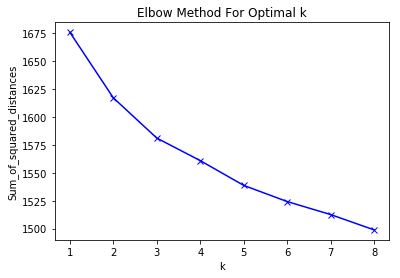

In [27]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# set number of clusters
kclusters = 5

merge_grouped_clustering = merge_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merge_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 3, 1, 2, 3, 3], dtype=int32)

In [29]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merge_xcluster = df_merge

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merge_xcluster = df_merge_xcluster.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [30]:
#In order to create the map, the type of cluster labels is changed from float to int.  
df_merge_xcluster = df_merge_xcluster.dropna(subset=['Cluster Labels'], axis=0)
df_merge_xcluster['Cluster Labels'] = df_merge_xcluster['Cluster Labels'].astype(int)

print("Dataframe shape:", df_merge_xcluster.shape) 
df_merge_xcluster.head()  # check the last columns!

Dataframe shape: (336, 16)


PostalCode           Borough                     Neighbourhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto                      Harbourfront  43.654260   
3        M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4        M7A  Downtown Toronto                      Queen's Park  43.662301   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.329656               1                  Park              Bus Stop   
1 -79.315572               1           Coffee Shop                  Park   
2 -79.360636               1           Coffee Shop               Theater   
3 -79.464763               1           Coffee Shop            Restaurant   
4 -79.389494               1           Coffee Shop             Gastropub   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Shopping Mall     Convenience Store              Pharmacy   
1   Sporting Goods Shop  Gym / Fitness Center           Golf Course   
2                  Café                 Diner                   Pub   
3          Dessert Shop        Clothing Store  Fast Food Restaurant   
4                  Park      Sushi Restaurant    Italian Restaurant   

  6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
0         Train Station  Caribbean Restaurant           Grocery Store   
1           Men's Store                Lounge            Hockey Arena   
2                  Park    Italian Restaurant              Restaurant   
3      Sushi Restaurant   Fried Chicken Joint  Furniture / Home Store   
4       Thai Restaurant           Pizza Place        Ramen Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0     Chinese Restaurant           Skating Rink  
1          Grocery Store  Portuguese Restaurant  
2                 Bakery         Breakfast Spot  
3  Vietnamese Restaurant      Korean Restaurant  
4             Restaurant                    Gym

Cluster Visualization for both cities

In [31]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map for Toronto
map_clusters_toronto = folium.Map(location=[43.715383, -79.405678], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge_xcluster['Latitude'], df_merge_xcluster['Longitude'], df_merge_xcluster['Neighbourhood'], df_merge_xcluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
       
map_clusters_toronto

In [32]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map for Istanbul
map_clusters_ist = folium.Map(location=[41.015137, 28.979530], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge_xcluster['Latitude'], df_merge_xcluster['Longitude'], df_merge_xcluster['Neighbourhood'], df_merge_xcluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ist)
       
map_clusters_ist

## 5.Cluster Analysis

In [33]:
df_merge_xcluster.head()

PostalCode           Borough                     Neighbourhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto                      Harbourfront  43.654260   
3        M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4        M7A  Downtown Toronto                      Queen's Park  43.662301   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.329656               1                  Park              Bus Stop   
1 -79.315572               1           Coffee Shop                  Park   
2 -79.360636               1           Coffee Shop               Theater   
3 -79.464763               1           Coffee Shop            Restaurant   
4 -79.389494               1           Coffee Shop             Gastropub   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Shopping Mall     Convenience Store              Pharmacy   
1   Sporting Goods Shop  Gym / Fitness Center           Golf Course   
2                  Café                 Diner                   Pub   
3          Dessert Shop        Clothing Store  Fast Food Restaurant   
4                  Park      Sushi Restaurant    Italian Restaurant   

  6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
0         Train Station  Caribbean Restaurant           Grocery Store   
1           Men's Store                Lounge            Hockey Arena   
2                  Park    Italian Restaurant              Restaurant   
3      Sushi Restaurant   Fried Chicken Joint  Furniture / Home Store   
4       Thai Restaurant           Pizza Place        Ramen Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0     Chinese Restaurant           Skating Rink  
1          Grocery Store  Portuguese Restaurant  
2                 Bakery         Breakfast Spot  
3  Vietnamese Restaurant      Korean Restaurant  
4             Restaurant                    Gym

In [34]:
#first Cluster
cluster0 = df_merge_xcluster.loc[df_merge_xcluster['Cluster Labels'] == 0, df_merge_xcluster.columns[[1,2] + list(range(5, df_merge_xcluster.shape[1]))]]
cluster0_hist= cluster0.drop(columns=['Borough','Neighbourhood','Cluster Labels'])

print("Dataframe shape:", cluster0_hist.shape) 
cluster0_hist.head()

Dataframe shape: (9, 10)


1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
12                   Park        Breakfast Spot    Italian Restaurant   
45                   Park                  Pool           Fabric Shop   
101                  Park    Italian Restaurant        Ice Cream Shop   
174            Campground                  Lake         Çöp Şiş Place   
176              Mountain                Forest     Mobile Phone Shop   

    4th Most Common Venue        5th Most Common Venue 6th Most Common Venue  \
12           Burger Joint                   Playground         Çöp Şiş Place   
45   Fast Food Restaurant               Farmers Market                  Farm   
101         Shopping Mall  Eastern European Restaurant                  Food   
174   Filipino Restaurant         Ethiopian Restaurant         Event Service   
176           Golf Course                         Lake        Farmers Market   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
12     Falafel Restaurant              Festival  Fast Food Restaurant   
45     Falafel Restaurant               Factory         Çöp Şiş Place   
101     Fondue Restaurant     Electronics Store     Elementary School   
174           Event Space               Exhibit           Fabric Shop   
176                 Field              Festival  Fast Food Restaurant   

    10th Most Common Venue  
12          Farmers Market  
45                Festival  
101     English Restaurant  
174                Factory  
176                   Farm

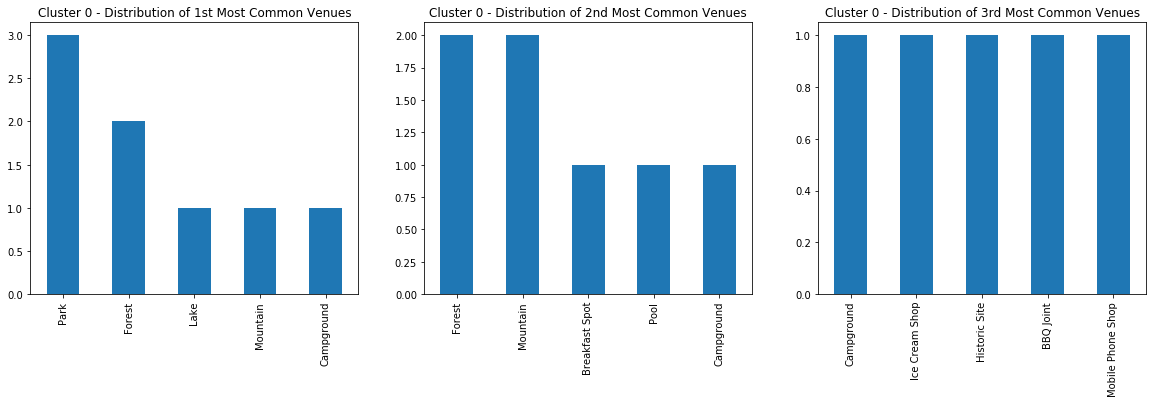

In [35]:
import seaborn as sns
fig = plt.figure()
ax0=fig.add_subplot(1,3,1)
ax1=fig.add_subplot(1,3,2)
ax2=fig.add_subplot(1,3,3)

cluster0_hist['1st Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax0)
ax0.set_title('Cluster 0 - Distribution of 1st Most Common Venues')
ax0.set_xlim([None,4.5])
cluster0_hist['2nd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax1)
ax1.set_title('Cluster 0 - Distribution of 2nd Most Common Venues')
ax1.set_xlim([None,4.5])
cluster0_hist['3rd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax2)
ax2.set_title('Cluster 0 - Distribution of 3rd Most Common Venues')
ax2.set_xlim([None,4.5])

plt.show()

In [36]:
#second Cluster
cluster1 = df_merge_xcluster.loc[df_merge_xcluster['Cluster Labels'] == 1, df_merge_xcluster.columns[[1,2] + list(range(5, df_merge_xcluster.shape[1]))]]
cluster1_hist= cluster1.drop(columns=['Borough','Neighbourhood','Cluster Labels'])

print("Dataframe shape:", cluster1_hist.shape) 
cluster1_hist.head()

Dataframe shape: (141, 10)


1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park              Bus Stop         Shopping Mall   
1           Coffee Shop                  Park   Sporting Goods Shop   
2           Coffee Shop               Theater                  Café   
3           Coffee Shop            Restaurant          Dessert Shop   
4           Coffee Shop             Gastropub                  Park   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Convenience Store              Pharmacy         Train Station   
1  Gym / Fitness Center           Golf Course           Men's Store   
2                 Diner                   Pub                  Park   
3        Clothing Store  Fast Food Restaurant      Sushi Restaurant   
4      Sushi Restaurant    Italian Restaurant       Thai Restaurant   

  7th Most Common Venue   8th Most Common Venue  9th Most Common Venue  \
0  Caribbean Restaurant           Grocery Store     Chinese Restaurant   
1                Lounge            Hockey Arena          Grocery Store   
2    Italian Restaurant              Restaurant                 Bakery   
3   Fried Chicken Joint  Furniture / Home Store  Vietnamese Restaurant   
4           Pizza Place        Ramen Restaurant             Restaurant   

  10th Most Common Venue  
0           Skating Rink  
1  Portuguese Restaurant  
2         Breakfast Spot  
3      Korean Restaurant  
4                    Gym

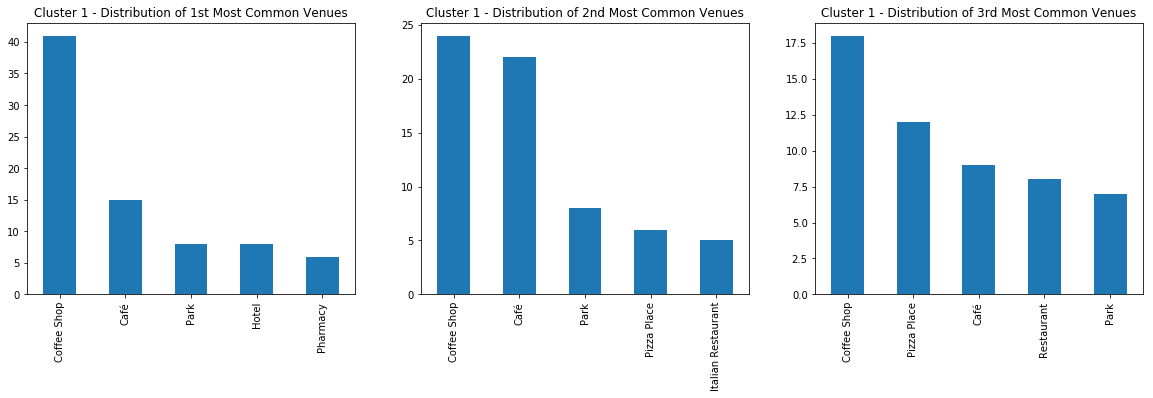

In [37]:
import seaborn as sns
fig = plt.figure()
ax0=fig.add_subplot(1,3,1)
ax1=fig.add_subplot(1,3,2)
ax2=fig.add_subplot(1,3,3)

cluster1_hist['1st Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax0)
ax0.set_title('Cluster 1 - Distribution of 1st Most Common Venues')
ax0.set_xlim([None,4.5])
cluster1_hist['2nd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax1)
ax1.set_title('Cluster 1 - Distribution of 2nd Most Common Venues')
ax1.set_xlim([None,4.5])
cluster1_hist['3rd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax2)
ax2.set_title('Cluster 1 - Distribution of 3rd Most Common Venues')
ax2.set_xlim([None,4.5])

plt.show()

In [38]:
#third Cluster
cluster2 = df_merge_xcluster.loc[df_merge_xcluster['Cluster Labels'] == 2, df_merge_xcluster.columns[[1,2] + list(range(5, df_merge_xcluster.shape[1]))]]
cluster2_hist= cluster2.drop(columns=['Borough','Neighbourhood','Cluster Labels'])

print("Dataframe shape:", cluster2_hist.shape) 
cluster2_hist.head()

Dataframe shape: (7, 10)


1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
138                  Farm                   Bay         Çöp Şiş Place   
169              Mountain     Recreation Center                  Farm   
173                  Farm             Surf Spot             Cafeteria   
175                  Café              Mountain               Brewery   
216                Casino                  Farm         Çöp Şiş Place   

    4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
138   Filipino Restaurant  Entertainment Service  Ethiopian Restaurant   
169         Çöp Şiş Place                Factory              Festival   
173              Mountain        Harbor / Marina            Campground   
175                  Farm          Çöp Şiş Place    Falafel Restaurant   
216     Elementary School  Entertainment Service  Ethiopian Restaurant   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
138         Event Service           Event Space               Exhibit   
169  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
173         Çöp Şiş Place    Falafel Restaurant  Fast Food Restaurant   
175              Festival  Fast Food Restaurant        Farmers Market   
216         Event Service           Event Space               Exhibit   

    10th Most Common Venue  
138            Fabric Shop  
169                Exhibit  
173         Farmers Market  
175            Fabric Shop  
216            Fabric Shop

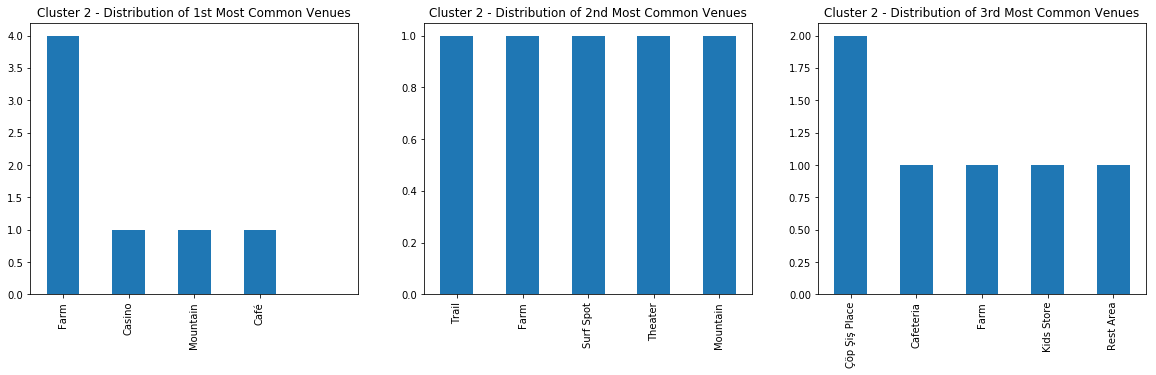

In [39]:
import seaborn as sns
fig = plt.figure()
ax0=fig.add_subplot(1,3,1)
ax1=fig.add_subplot(1,3,2)
ax2=fig.add_subplot(1,3,3)

cluster2_hist['1st Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax0)
ax0.set_title('Cluster 2 - Distribution of 1st Most Common Venues')
ax0.set_xlim([None,4.5])
cluster2_hist['2nd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax1)
ax1.set_title('Cluster 2 - Distribution of 2nd Most Common Venues')
ax1.set_xlim([None,4.5])
cluster2_hist['3rd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax2)
ax2.set_title('Cluster 2 - Distribution of 3rd Most Common Venues')
ax2.set_xlim([None,4.5])

plt.show()

In [40]:
#forth Cluster
cluster3 = df_merge_xcluster.loc[df_merge_xcluster['Cluster Labels'] == 3, df_merge_xcluster.columns[[1,2] + list(range(5, df_merge_xcluster.shape[1]))]]
cluster3_hist= cluster3.drop(columns=['Borough','Neighbourhood','Cluster Labels'])

print("Dataframe shape:", cluster3_hist.shape) 
cluster3_hist.head()

Dataframe shape: (178, 10)


1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
61                   Café  Gym / Fitness Center          College Quad   
107                  Café            Steakhouse  Gym / Fitness Center   
110    Seafood Restaurant                  Café            Restaurant   
111                  Café            Restaurant           Coffee Shop   
112             Nightclub                  Café            Restaurant   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
61                   Park           Coffee Shop           College Gym   
107           Coffee Shop                Bakery            Restaurant   
110                Lounge                  Park           Coffee Shop   
111                Lounge            Steakhouse  Gym / Fitness Center   
112                 Hotel    Turkish Restaurant        Breakfast Spot   

    7th Most Common Venue 8th Most Common Venue  \
61                  Trail             Bookstore   
107    Italian Restaurant      Kebab Restaurant   
110                Bakery           Manti Place   
111        Ice Cream Shop          Dessert Shop   
112    Seafood Restaurant        Sandwich Place   

             9th Most Common Venue 10th Most Common Venue  
61                     Flea Market                   Food  
107  Vegetarian / Vegan Restaurant            Pastry Shop  
110                            Gym            Art Gallery  
111              Electronics Store                   Park  
112                         Bakery            Music Venue

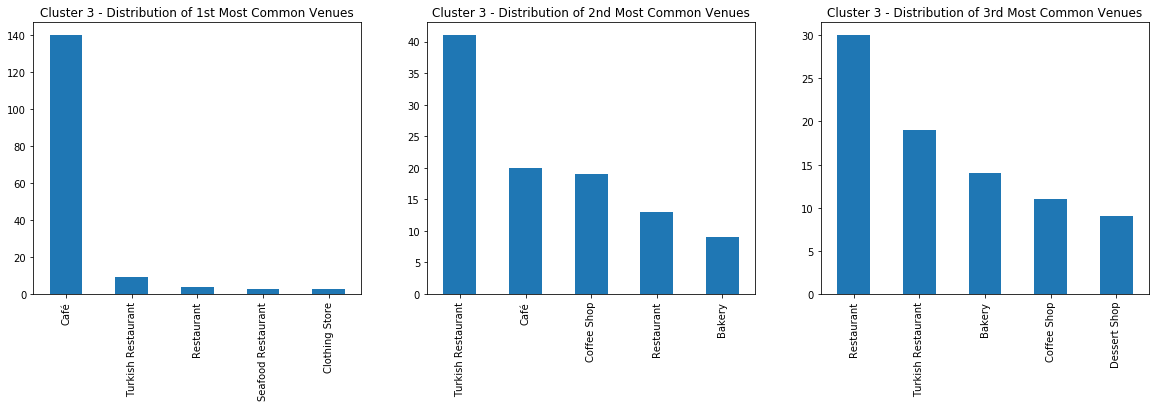

In [41]:
import seaborn as sns
fig = plt.figure()
ax0=fig.add_subplot(1,3,1)
ax1=fig.add_subplot(1,3,2)
ax2=fig.add_subplot(1,3,3)

cluster3_hist['1st Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax0)
ax0.set_title('Cluster 3 - Distribution of 1st Most Common Venues')
ax0.set_xlim([None,4.5])
cluster3_hist['2nd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax1)
ax1.set_title('Cluster 3 - Distribution of 2nd Most Common Venues')
ax1.set_xlim([None,4.5])
cluster3_hist['3rd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax2)
ax2.set_title('Cluster 3 - Distribution of 3rd Most Common Venues')
ax2.set_xlim([None,4.5])

plt.show()

In [42]:
#fifth Cluster
cluster4 = df_merge_xcluster.loc[df_merge_xcluster['Cluster Labels'] == 4, df_merge_xcluster.columns[[1,2] + list(range(5, df_merge_xcluster.shape[1]))]]
cluster4_hist= cluster4.drop(columns=['Borough','Neighbourhood','Cluster Labels'])

print("Dataframe shape:", cluster4_hist.shape) 
cluster4_hist.head()

Dataframe shape: (1, 10)


1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
94           Coffee Shop         Çöp Şiş Place                 Field   

   4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
94    English Restaurant  Entertainment Service  Ethiopian Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
94         Event Service           Event Space               Exhibit   

   10th Most Common Venue  
94            Fabric Shop

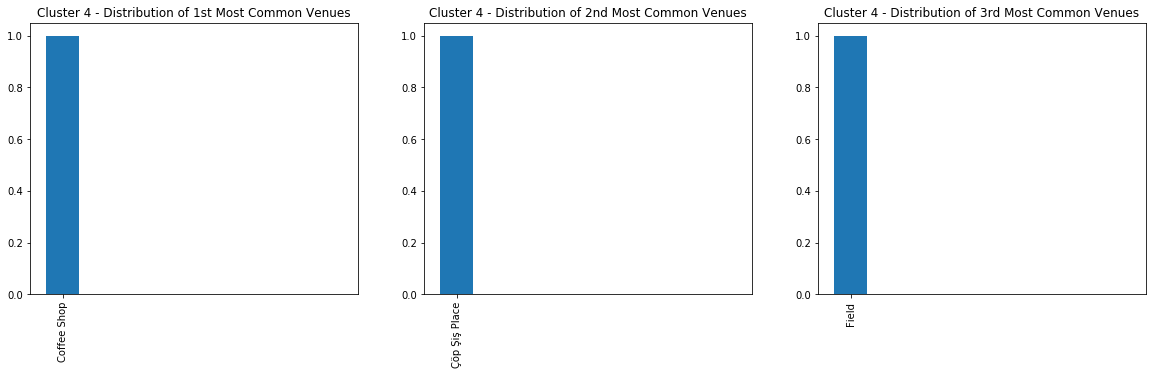

In [43]:
import seaborn as sns
fig = plt.figure()
ax0=fig.add_subplot(1,3,1)
ax1=fig.add_subplot(1,3,2)
ax2=fig.add_subplot(1,3,3)

cluster4_hist['1st Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax0)
ax0.set_title('Cluster 4 - Distribution of 1st Most Common Venues')
ax0.set_xlim([None,4.5])
cluster4_hist['2nd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax1)
ax1.set_title('Cluster 4 - Distribution of 2nd Most Common Venues')
ax1.set_xlim([None,4.5])
cluster4_hist['3rd Most Common Venue'].value_counts().plot(kind='bar', figsize=(20,5), ax=ax2)
ax2.set_title('Cluster 4 - Distribution of 3rd Most Common Venues')
ax2.set_xlim([None,4.5])

plt.show()

## 6.Airbnb Data

In [44]:
#Toronto listing data
!wget -q -O 'listings.csv' http://data.insideairbnb.com/canada/on/toronto/2019-12-07/visualisations/listings.csv
print('Data downloaded! - Toronto listings')
toronto_listings = pd.read_csv('listings.csv')
#Istanbul listing data
!wget -q -O 'listings.csv' http://data.insideairbnb.com/turkey/marmara/istanbul/2019-11-29/visualisations/listings.csv
print('Data downloaded! - Istanbul listings')
istanbul_listings = pd.read_csv('listings.csv')






Data downloaded! - Toronto listings
Data downloaded! - Istanbul listings


In [45]:
#Toronto geojson
!wget --quiet http://data.insideairbnb.com/canada/on/toronto/2019-12-07/visualisations/neighbourhoods.geojson -O toronto_neighbourhoods.json
print('GeoJSON file downloaded! - Toronto')
toronto_geo = r'toronto_neighbourhoods.json' # geojson file
#istanbul geojson
!wget --quiet http://data.insideairbnb.com/turkey/marmara/istanbul/2019-11-29/visualisations/neighbourhoods.geojson -O istanbul_neighbourhoods.json
print('GeoJSON file downloaded! - Istanbul')
istanbul_geo = r'istanbul_neighbourhoods.json' # geojson file


GeoJSON file downloaded! - Toronto
GeoJSON file downloaded! - Istanbul


## 7.Toronto Choropleth Map

In [46]:
toronto_choropleth = toronto_listings[['neighbourhood','price']]
toronto_chor_grouped = toronto_choropleth.groupby(['neighbourhood']).mean()


print("Dataframe shape:", toronto_chor_grouped.shape) 
toronto_chor_grouped.reset_index(inplace=True)

toronto_chor_grouped.head()


Dataframe shape: (140, 1)


neighbourhood       price
0               Agincourt North   64.372549
1  Agincourt South-Malvern West   80.436893
2                     Alderwood  120.515152
3                         Annex  173.320799
4             Banbury-Don Mills  162.212121

In [47]:


# create map for Toronto
toronto_chor = folium.Map(location=[43.715383, -79.405678], zoom_start=11)


# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
toronto_chor.choropleth(
    geo_data=toronto_geo,
    data=toronto_chor_grouped,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Toronto Average Daily Rent Prices by Neighbourhood - USD'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge_xcluster['Latitude'], df_merge_xcluster['Longitude'], df_merge_xcluster['Neighbourhood'], df_merge_xcluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_chor)



# display map
toronto_chor



## 8.Istanbul Choropleth Map

In [48]:
ist_choropleth = istanbul_listings[['neighbourhood','price']]
ist_chor_grouped = ist_choropleth.groupby(['neighbourhood']).mean()


print("Dataframe shape:", ist_chor_grouped.shape) 
ist_chor_grouped.reset_index(inplace=True)

ist_chor_grouped.head()

Dataframe shape: (39, 1)


neighbourhood       price
0        Adalar  791.128834
1    Arnavutkoy  614.500000
2      Atasehir  274.423913
3       Avcilar  238.121212
4      Bagcilar  403.656000

In [49]:
#Web scraping is used to get try/usd ratio
html_doc = requests.get('https://www.bloomberght.com/doviz/dolar').text
soup = BeautifulSoup(html_doc, 'lxml')
x=soup.find('span', class_='downRed').text

y=x.split(',')
z=y[0]+'.'+y[1]
c=float(z)
ist_chor_grouped['usd'] = ist_chor_grouped['price']/c

ist_chor_grouped_usd =ist_chor_grouped.drop(columns=['price'])

ist_chor_grouped_usd.head()

neighbourhood         usd
0        Adalar  129.793256
1    Arnavutkoy  100.815382
2      Atasehir   45.022216
3       Avcilar   39.066365
4      Bagcilar   66.224140

In [50]:
# create map for Istanbul
istanbul_chor = folium.Map(location=[41.015137, 28.979530], zoom_start=11)


# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
istanbul_chor.choropleth(
    geo_data=istanbul_geo,
    data=ist_chor_grouped_usd,
    columns=['neighbourhood', 'usd'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Istanbul Average Daily Rent Prices by Neighbourhood - USD'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge_xcluster['Latitude'], df_merge_xcluster['Longitude'], df_merge_xcluster['Neighbourhood'], df_merge_xcluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(istanbul_chor)



# display map
istanbul_chor

END